


# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import re

In [2]:
anime = pd.read_csv("anime.csv", low_memory=False)
rating = pd.read_csv("rating.csv")

In [3]:
data = anime.merge(rating, on='anime_id')

In [4]:
data.head()

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1


# Анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   anime_id  int64  
 1   name      object 
 2   genre     object 
 3   type      object 
 4   episodes  object 
 5   rating_x  float64
 6   members   int64  
 7   user_id   int64  
 8   rating_y  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 536.5+ MB


# Обработка данных

In [11]:
df = data.copy()
df = df[df['rating_y'] != -1]
df.drop(columns=["anime_id", "episodes"], axis=1, inplace=True)
df.rename(columns={"rating_x": "avg_rating", "rating_y": "user_rating"}, inplace=True)

удаляю строки с рейтингом -1, ненужные столбцы для рекомендаций anime_Id и episodes, меняю название столбцов

# Визуализация

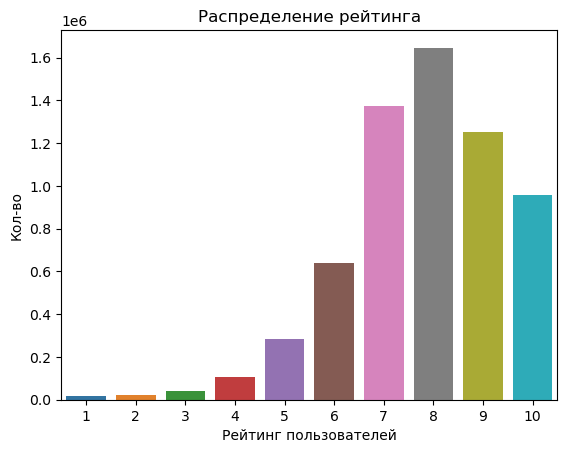

In [12]:
sns.countplot(data=df, x='user_rating')
plt.xlabel('Рейтинг пользователей')
plt.ylabel('Кол-во')
plt.title('Распределение рейтинга')
plt.show()


# Взвешенный рейтинг

In [13]:
# средний рейтинг
avg_ratings = df.groupby('name')['user_rating'].mean().reset_index().rename(columns={'user_rating': 'avg_user_rating'})
# кол-во лайков для каждого аниме
cnt_ratings = df.groupby('name')['user_rating'].count().reset_index().rename(columns={'user_rating': 'count_user_rating'})
popularity = avg_ratings.merge(cnt_ratings, on='name')


In [14]:
popularity.head()

,name,avg_user_rating,count_user_rating
0,&quot;0&quot;,4.764706,17
1,&quot;Aesop&quot; no Ohanashi yori: Ushi to Ka...,1.000000,1
2,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hat...,7.343307,635
3,&quot;Bungaku Shoujo&quot; Memoire,7.744713,662
4,&quot;Bungaku Shoujo&quot; Movie,7.840154,1295


In [17]:
v = popularity["count_user_rating"]
R = popularity["avg_user_rating"]
m = v.quantile(0.90)
c = R.mean()
popularity['weighted_score'] = ((v * R) + (m * c)) / (v + m)

# сортировка
popularity_sorted = popularity.sort_values('weighted_score', ascending=False)
top_10_anime = popularity_sorted.head(10)
top_10_anime.head()

,name,avg_user_rating,count_user_rating,weighted_score
2373,Fullmetal Alchemist: Brotherhood,9.322741,21494,9.127122
8283,Steins;Gate,9.261326,17151,9.026119
1388,Clannad: After Story,9.165292,15518,8.917189
1419,Code Geass: Hangyaku no Lelouch R2,9.059837,21124,8.880510
1415,Code Geass: Hangyaku no Lelouch,8.927796,24126,8.777962


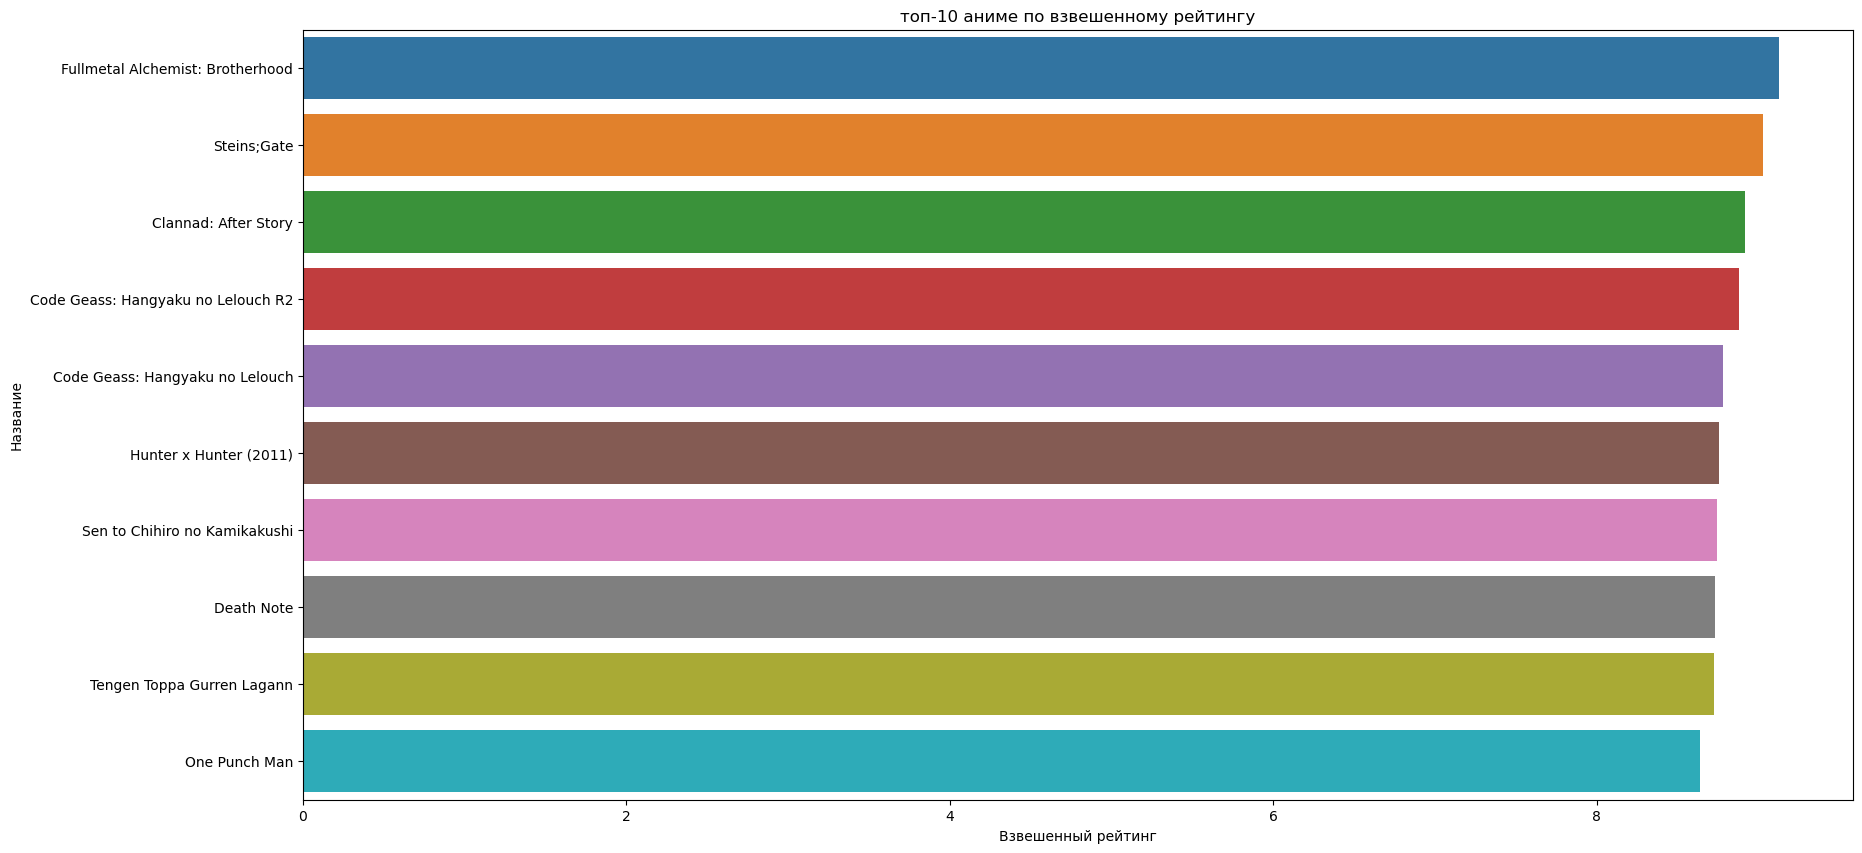

In [16]:
plt.figure(figsize=(20, 10))
sns.barplot(x='weighted_score', y='name', data=top_10_anime)
plt.xlabel('Взвешенный рейтинг')
plt.ylabel('Название')
plt.title('топ-10 аниме по взвешенному рейтингу')
plt.show()


топ-10 аниме по взвешенному рейтингу

# Коллаборативная фильтрация 

In [15]:
# отбираем пользователей,которые поставили 200 и больше лайков
popular_users = df[df['user_id'].map(df['user_id'].value_counts()) > 200]

user_pivot = popular_users.pivot_table(index="user_id", columns="name", values="user_rating").fillna(0)

In [38]:
user_pivot.head()

name,&quot;0&quot;,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,...,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,◯
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,7.0,7.0,0.0,0.0,7.0,0.0


# Коллаборативная фильтрация

In [59]:
anime_matrix = csr_matrix(user_pivot.values)

def find_similar_knn(anime_title, num_neighbors=10):
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(anime_matrix)
    anime_index = user_pivot.columns.get_loc(anime_title)
    distances, indices = model_knn.kneighbors(anime_matrix[anime_index], n_neighbors=num_neighbors + 1)
    similar_anime = [user_pivot.columns[idx] for idx in indices[0][1:]]
    return pd.DataFrame({"Similar Anime": similar_anime})


# Косинусное сходство

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_score = cosine_similarity(user_pivot.T)
user_pivot_T = user_pivot.T

In [61]:
user_pivot_T.head()

user_id,5,7,17,38,43,46,123,129,139,160,...,73406,73417,73422,73457,73460,73476,73499,73502,73503,73507
name,,,,,,,,,,,,,,,,,,,,,
&quot;0&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
&quot;Eiji&quot;,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
def recommend(anime_title):
    index = np.where(user_pivot_T.index == anime_title)[0][0]
    similar_anime = sorted(list(enumerate(similarity_score[index])), key=lambda x: x[1], reverse=True)[1:11]
    
    recommendations = []
    for i in similar_anime:
        temp_df = anime[anime['name'] == user_pivot_T.index[i[0]]]
        item = [temp_df.drop_duplicates('name')['name'].values[0],
                temp_df.drop_duplicates('name')['genre'].values[0]]
        recommendations.append(item)
    return pd.DataFrame(recommendations, columns=["Anime Title", "Genre"])

# Рекомендации


In [63]:
similar_anime_knn = find_similar_knn("Kimi no Na wa.")
print("Аниме,похожие на 'Kimi no Na wa.' по модели ближ соседей:")
print(similar_anime_knn)


Аниме, похожие на 'Kimi no Na wa.' по модели KNN:
                                       Similar Anime
0                          Manyuu Hikenchou Specials
1            Hetalia: The Beautiful World Extra Disc
2  Kuroko no Basket Movie 1: Winter Cup Soushuuhe...
3                             Makiba no Shoujo Katri
4  Peeping Life: Tezuka Pro - Tatsunoko Pro Wonde...
5  Girls und Panzer Heartful Tank Disc Picture Drama
6                 Kaichou wa Maid-sama!: Omake dayo!
7                                  Kinnikuman II Sei
8                                    Assemble Insert
9                 El Hazard 2: The Magnificent World


In [64]:
recommendations = recommend("Kimi no Na wa.")
print("Аниме,похожие на 'Kimi no Na wa.' на основе косинусного сходства:")
print(recommendations)

Рекомендации для 'Kimi no Na wa.' на основе косинусного сходства:
                             Anime Title  \
0                Boku dake ga Inai Machi   
1                Shigatsu wa Kimi no Uso   
2  Re:Zero kara Hajimeru Isekai Seikatsu   
3                                 ReLIFE   
4                               Noragami   
5                              Charlotte   
6                       Noragami Aragoto   
7                          One Punch Man   
8                            Tokyo Ghoul   
9                        No Game No Life   

                                               Genre  
0       Mystery, Psychological, Seinen, Supernatural  
1             Drama, Music, Romance, School, Shounen  
2            Drama, Fantasy, Psychological, Thriller  
3                     Romance, School, Slice of Life  
4           Action, Adventure, Shounen, Supernatural  
5                         Drama, School, Super Power  
6           Action, Adventure, Shounen, Supernatural  
7  Action